In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, utils, layers, models, losses, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10
feature_dims = 2

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = utils.to_categorical(y_train, num_classes = num_classes)
y_test = utils.to_categorical(y_test, num_classes = num_classes)

11490434/11490434 [==============================] - 0s 0us/step


# CenterLoss無し

In [4]:
def build_model():
    input = layers.Input(shape = x_train.shape[1:])
    x = layers.Flatten()(input)
    x = layers.Dense(units = 128, activation = "tanh")(x)
    feature = layers.Dense(units = feature_dims, activation = "linear", name = "feature")(x)
    output = layers.Dense(units = num_classes, activation = "softmax", name = "output")(feature)

    return models.Model(input, [feature, output])

In [23]:
model = build_model()
model.compile(loss = {"output" : losses.CategoricalCrossentropy()},
              optimizer = optimizers.Adam(learning_rate = 0.001),
              metrics = {"output" : metrics.CategoricalAccuracy()})

history_1 = model.fit(x = x_train, y = {"output" : y_train}, epochs = 15, batch_size = 256,
                      validation_data = (x_test, {"output" : y_test}))

Epoch 1/15
235/235 [==============================] - 3s 6ms/step - loss: 1.4633 - output_loss: 1.4633 - output_categorical_accuracy: 0.4469 - val_loss: 1.0299 - val_output_loss: 1.0299 - val_output_categorical_accuracy: 0.6525
Epoch 2/15
235/235 [==============================] - 1s 5ms/step - loss: 0.8631 - output_loss: 0.8631 - output_categorical_accuracy: 0.7256 - val_loss: 0.7439 - val_output_loss: 0.7439 - val_output_categorical_accuracy: 0.7689
Epoch 3/15
235/235 [==============================] - 1s 5ms/step - loss: 0.6603 - output_loss: 0.6603 - output_categorical_accuracy: 0.8083 - val_loss: 0.6097 - val_output_loss: 0.6097 - val_output_categorical_accuracy: 0.8450
Epoch 4/15
235/235 [==============================] - 1s 6ms/step - loss: 0.5491 - output_loss: 0.5491 - output_categorical_accuracy: 0.8618 - val_loss: 0.5319 - val_output_loss: 0.5319 - val_output_categorical_accuracy: 0.8791
Epoch 5/15
235/235 [==============================] - 2s 7ms/step - loss: 0.4732 - outpu

313/313 [==============================] - 1s 2ms/step


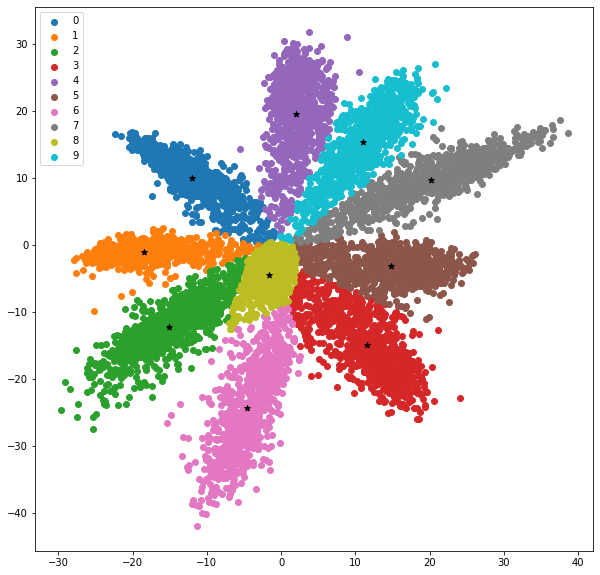

In [24]:
# テストデータの中間表現を取得
feature_extractor = models.Model(inputs=model.input, outputs=model.get_layer('feature').output)
features = feature_extractor.predict(x_test)

# テストデータのクラス分類結果を取得
y_pred = np.argmax(model.predict(x_test)[1], axis=-1)

# 中間表現を2次元の散布図でプロット
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
for i in range(num_classes):
    ax.scatter(features[y_pred==i, 0], features[y_pred==i, 1], label = f"{i}")
for i in range(num_classes):
    x = sum(features[y_pred==i, 0]) / len(features[y_pred==i, 0])
    y = sum(features[y_pred==i, 1]) / len(features[y_pred==i, 1])
    ax.scatter(x, y, color = "black", marker = "*")
ax.legend()

# CenterLossあり

In [13]:
class CenterLoss(losses.Loss):
    def __init__(self, num_classes, feature_dims, alpha = 0.5):
        super(CenterLoss, self).__init__()

        self.num_classes = num_classes
        self.feature_dims = feature_dims
        # hyper parameter for updating the center point
        self.alpha = alpha

        self.centers = tf.Variable(tf.zeros(shape = (self.num_classes, self.feature_dims)))
    
    def call(self, y_true, y_pred):
        """
            y_ture : same teacher signal as for classification (1-hot vector)
                     shape = (batch_size, num_classes)
            y_pred : output of features in the middle layer of the model
                     shape = (batch_size, feature_dims)
        """
        # one-hotベクトルを整数に変換
        labels = tf.argmax(y_true, axis=-1)
        # 教師信号にある中央の座標のみ取得
        centers_batch = tf.gather(self.centers, labels)
        # 中央の座標と予測の差を取得
        diff = centers_batch - y_pred
        # 損失を計算
        loss = tf.reduce_mean(tf.square(diff))

        # 教師信号に各カテゴリが何回登場したか取得
        unique_label, unique_idx, unique_count = tf.unique_with_counts(labels)
        appear_times = tf.gather(unique_count, unique_idx)
        appear_times = tf.reshape(appear_times, [-1, 1])
        # 中央の座標と予測の差をカテゴリが登場した回数で割る
        diff = diff / tf.cast((1 + appear_times), tf.float32)
        
        diff = self.alpha * diff
        # 中央の点を更新
        self.centers = tf.compat.v1.scatter_sub(self.centers, labels, diff)
        
        return loss

In [25]:
model = build_model()
model.compile(loss = {"feature" : CenterLoss(num_classes, feature_dims), "output" : losses.CategoricalCrossentropy()},
              optimizer = optimizers.Adam(learning_rate = 0.001),
              metrics = {"output" : metrics.CategoricalAccuracy()})

history_2 = model.fit(x = x_train, y = {"feature" : y_train, "output" : y_train}, epochs = 15, batch_size = 256,
                      validation_data = (x_test, {"output" : y_test}))

Epoch 1/15
235/235 [==============================] - 4s 7ms/step - loss: 1.9372 - feature_loss: 0.1680 - output_loss: 1.7692 - output_categorical_accuracy: 0.4288 - val_loss: 1.5621 - val_feature_loss: 0.0000e+00 - val_output_loss: 1.5621 - val_output_categorical_accuracy: 0.4680
Epoch 2/15
235/235 [==============================] - 1s 6ms/step - loss: 1.5911 - feature_loss: 0.1954 - output_loss: 1.3958 - output_categorical_accuracy: 0.5083 - val_loss: 1.2880 - val_feature_loss: 0.0000e+00 - val_output_loss: 1.2880 - val_output_categorical_accuracy: 0.5423
Epoch 3/15
235/235 [==============================] - 1s 6ms/step - loss: 1.3740 - feature_loss: 0.1936 - output_loss: 1.1804 - output_categorical_accuracy: 0.5849 - val_loss: 1.1156 - val_feature_loss: 0.0000e+00 - val_output_loss: 1.1156 - val_output_categorical_accuracy: 0.6327
Epoch 4/15
235/235 [==============================] - 1s 6ms/step - loss: 1.2288 - feature_loss: 0.1879 - output_loss: 1.0409 - output_categorical_accurac

313/313 [==============================] - 1s 2ms/step


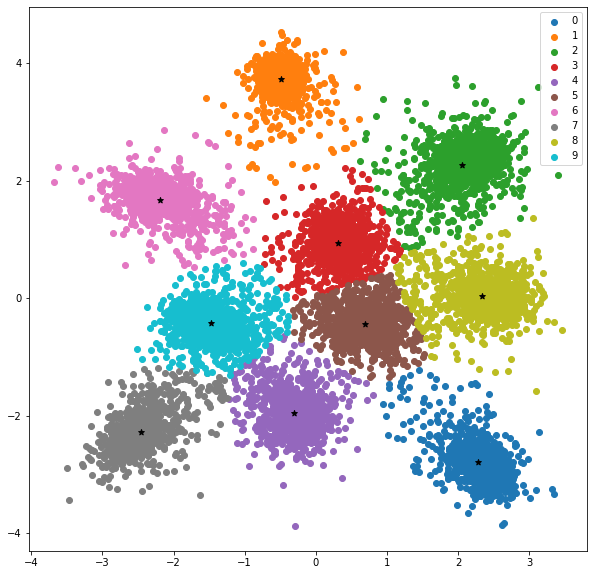

In [26]:
# テストデータの中間表現を取得
feature_extractor = models.Model(inputs=model.input, outputs=model.get_layer('feature').output)
features = feature_extractor.predict(x_test)

# テストデータのクラス分類結果を取得
y_pred = np.argmax(model.predict(x_test)[1], axis=-1)

# 中間表現を2次元の散布図でプロット
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
for i in range(num_classes):
    ax.scatter(features[y_pred==i, 0], features[y_pred==i, 1], label = f"{i}")
for i in range(num_classes):
    x = sum(features[y_pred==i, 0]) / len(features[y_pred==i, 0])
    y = sum(features[y_pred==i, 1]) / len(features[y_pred==i, 1])
    ax.scatter(x, y, color = "black", marker = "*")
ax.legend()

# 損失, 精度を比較

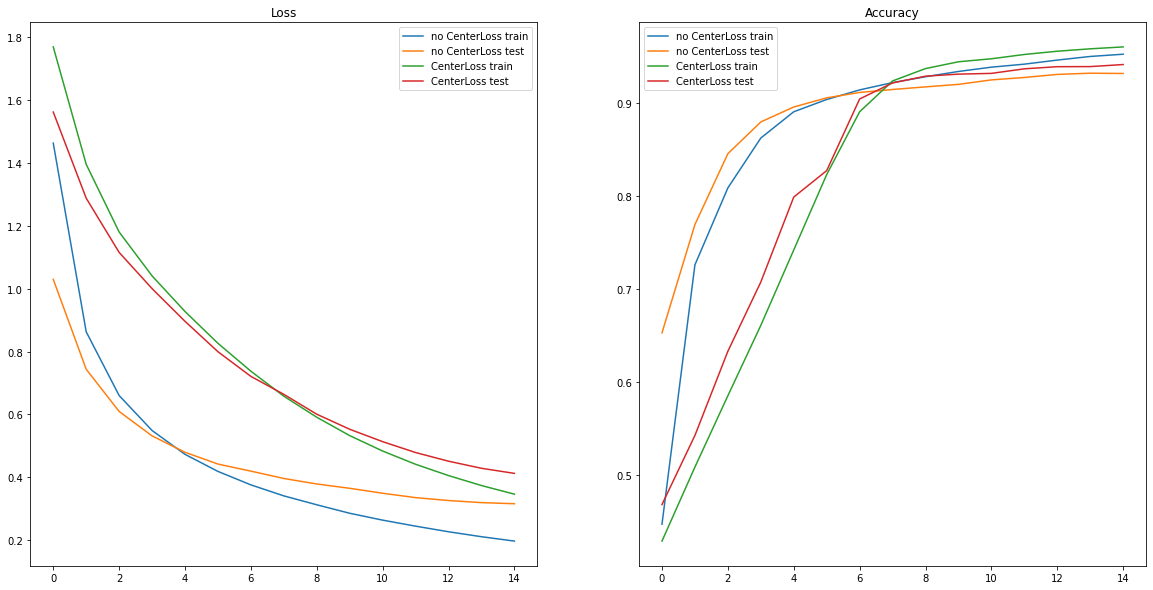

In [30]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history_1.history["output_loss"], label = "no CenterLoss train")
ax.plot(history_1.history["val_output_loss"], label = "no CenterLoss test")
ax.plot(history_2.history["output_loss"], label = "CenterLoss train")
ax.plot(history_2.history["val_output_loss"], label = "CenterLoss test")
ax.set_title("Loss")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_1.history["output_categorical_accuracy"], label = "no CenterLoss train")
ax.plot(history_1.history["val_output_categorical_accuracy"], label = "no CenterLoss test")
ax.plot(history_2.history["output_categorical_accuracy"], label = "CenterLoss train")
ax.plot(history_2.history["val_output_categorical_accuracy"], label = "CenterLoss test")
ax.set_title("Accuracy")
ax.legend()